Copyright (c) Microsoft Corporation. All rights reserved.

Licensed under the MIT License.

![Impressions](https://PixelServer20190423114238.azurewebsites.net/api/impressions/MachineLearningNotebooks/how-to-use-azureml/automated-machine-learning/classification-with-onnx/auto-ml-classification-with-onnx.png)

# Automated Machine Learning
_**Classification with Local Compute**_

## Contents
1. [Introduction](#Introduction)
1. [Setup](#Setup)
1. [Data](#Data)
1. [Train](#Train)
1. [Results](#Results)
1. [Test](#Test)



## Introduction

In this example we use the scikit-learn's [digit dataset](http://scikit-learn.org/stable/datasets/index.html#optical-recognition-of-handwritten-digits-dataset) to showcase how you can use AutoML for a simple classification problem.

Make sure you have executed the [configuration](../../../configuration.ipynb) before running this notebook.

Please find the ONNX related documentations [here](https://github.com/onnx/onnx).

In this notebook you will learn how to:
1. Create an `Experiment` in an existing `Workspace`.
2. Configure AutoML using `AutoMLConfig`.
3. Train the model using local compute with ONNX compatible config on.
4. Explore the results and save the ONNX model.

## Setup

As part of the setup you have already created an Azure ML `Workspace` object. For AutoML you will need to create an `Experiment` object, which is a named object in a `Workspace` used to run experiments.

In [1]:
import logging

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import datasets
from sklearn.model_selection import train_test_split

import azureml.core
from azureml.core.experiment import Experiment
from azureml.core.workspace import Workspace
from azureml.train.automl import AutoMLConfig, constants

In [2]:
ws = Workspace.from_config()

# Choose a name for the experiment and specify the project folder.
experiment_name = 'automl-classification-onnx'
project_folder = './sample_projects/automl-classification-onnx'

experiment = Experiment(ws, experiment_name)

output = {}
output['SDK version'] = azureml.core.VERSION
output['Subscription ID'] = ws.subscription_id
output['Workspace Name'] = ws.name
output['Resource Group'] = ws.resource_group
output['Location'] = ws.location
output['Project Directory'] = project_folder
output['Experiment Name'] = experiment.name
pd.set_option('display.max_colwidth', -1)
outputDf = pd.DataFrame(data = output, index = [''])
outputDf.T

,
SDK version,1.0.43
Subscription ID,a20c82c7-4497-4d44-952a-3105f790e26b
Workspace Name,philly2aml-test-ws
Resource Group,PhillyTestRG
Location,westus2
Project Directory,./sample_projects/automl-classification-onnx
Experiment Name,automl-classification-onnx


## Prepare MNIST dataset
In order to train on the MNIST dataset we will first need to download it from Yan LeCun's web site directly and save them in a `data` folder locally.

MNIST dataset exists on local machine. Skip downloading.


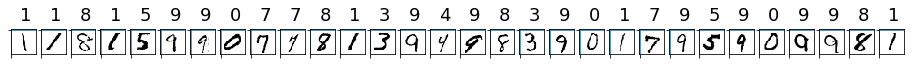

In [3]:
import os
import urllib
import numpy as np
import matplotlib.pyplot as plt

#
# Download if the dataset does not exist on local machine.
#

if not os.path.exists('./data/mnist'):
    os.makedirs('./data/mnist', exist_ok=True)
    urllib.request.urlretrieve('http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz', filename = './data/mnist/train-images.gz')
    urllib.request.urlretrieve('http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz', filename = './data/mnist/train-labels.gz')
    urllib.request.urlretrieve('http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz', filename = './data/mnist/test-images.gz')
    urllib.request.urlretrieve('http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz', filename = './data/mnist/test-labels.gz')
else:
    print("MNIST dataset exists on local machine. Skip downloading.")

#
# Load the dataset.
#

from src.utils import load_data

# Note we also shrink the intensity values (X) from 0-255 to 0-1.
X_train = load_data('./data/mnist/train-images.gz', False) / 255.0
y_train = load_data('./data/mnist/train-labels.gz', True).reshape(-1)

X_test = load_data('./data/mnist/test-images.gz', False) / 255.0
y_test = load_data('./data/mnist/test-labels.gz', True).reshape(-1)

#
# Show some sample images.
#

count = 0
sample_size = 30
plt.figure(figsize = (16, 6))
for i in np.random.permutation(X_train.shape[0])[:sample_size]:
    count = count + 1
    plt.subplot(1, sample_size, count)
    plt.axhline('')
    plt.axvline('')
    plt.text(x = 10, y = -10, s = y_train[i], fontsize = 18)
    plt.imshow(X_train[i].reshape(28, 28), cmap = plt.cm.Greys)
plt.show()

#
# Convert X_train and X_test to pandas DataFrame and set column names,
# This is needed for initializing the input variable names of ONNX model, 
# and the prediction with the ONNX model using the inference helper.
#

columns = []
for i in range(X_train.shape[1]):
    columns.append("C" + str(i + 1).zfill(3))
X_train_df = pd.DataFrame(X_train, columns=columns)
X_test_df = pd.DataFrame(X_test, columns=columns)

## Train with enable ONNX compatible models config on

Instantiate an `AutoMLConfig` object to specify the settings and data used to run the experiment.

Set the parameter enable_onnx_compatible_models=True, if you also want to generate the ONNX compatible models. Please note, the forecasting task and TensorFlow models are not ONNX compatible yet.

|Property|Description|
|-|-|
|**task**|classification or regression|
|**primary_metric**|This is the metric that you want to optimize. Classification supports the following primary metrics: <br><i>accuracy</i><br><i>AUC_weighted</i><br><i>average_precision_score_weighted</i><br><i>norm_macro_recall</i><br><i>precision_score_weighted</i>|
|**iteration_timeout_minutes**|Time limit in minutes for each iteration.|
|**iterations**|Number of iterations. In each iteration AutoML trains a specific pipeline with the data.|
|**X**|(sparse) array-like, shape = [n_samples, n_features]|
|**y**|(sparse) array-like, shape = [n_samples, ], Multi-class targets.|
|**enable_onnx_compatible_models**|Enable the ONNX compatible models in the experiment.|
|**path**|Relative path to the project folder. AutoML stores configuration files for the experiment under this folder. You can specify a new empty folder.|

In [4]:
automl_config = AutoMLConfig(task = 'classification',
                             debug_log = os.path.join(project_folder, 'automl_errors.log'),
                             primary_metric = 'AUC_weighted',
                             iteration_timeout_minutes = 60,
                             iterations = 5,
                             verbosity = logging.INFO,
                             X = X_train_df,
                             y = y_train,
                             preprocess=True,
                             enable_onnx_compatible_models=True,
                             path = project_folder)

Call the `submit` method on the experiment object and pass the run configuration. Execution of local runs is synchronous. Depending on the data and the number of iterations this can run for a while.
In this example, we specify `show_output = True` to print currently running iterations to the console.

In [5]:
local_run = experiment.submit(automl_config, show_output = True)

Running on local machine
Parent Run ID: AutoML_0d63d207-35f4-4165-8e58-e51f0d73bf93
Current status: DatasetFeaturization. Beginning to featurize the dataset.
Current status: DatasetEvaluation. Gathering dataset statistics.
Current status: FeaturesGeneration. Generating features for the dataset.
Current status: DatasetFeaturizationCompleted. Completed featurizing the dataset.
Current status: DatasetEvaluation. Gathering dataset statistics.
Current status: FeaturesGeneration. Generating features for the dataset.
Current status: ModelSelection. Beginning model selection.

****************************************************************************************************
ITERATION: The iteration being evaluated.
PIPELINE: A summary description of the pipeline being evaluated.
DURATION: Time taken for the current iteration.
METRIC: The result of computing score on the fitted pipeline.
BEST: The best observed score thus far.
******************************************************************

In [6]:
local_run

Experiment,Id,Type,Status,Details Page,Docs Page
automl-classification-onnx,AutoML_0d63d207-35f4-4165-8e58-e51f0d73bf93,automl,Completed,Link to Azure Portal,Link to Documentation


## Results

#### Widget for Monitoring Runs

The widget will first report a "loading" status while running the first iteration. After completing the first iteration, an auto-updating graph and table will be shown. The widget will refresh once per minute, so you should see the graph update as child runs complete.

**Note:** The widget displays a link at the bottom. Use this link to open a web interface to explore the individual run details.

In [7]:
from azureml.widgets import RunDetails
RunDetails(local_run).show() 

_AutoMLWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': True, 'log_level': 'INFO', 'sd…

### Retrieve the best ONNX model

Below we select the best pipeline from our iterations. The `get_output` method returns the best run and the fitted model. The Model includes the pipeline and any pre-processing.  Overloads on `get_output` allow you to retrieve the best run and fitted model for *any* logged metric or for a particular *iteration*.

Set the parameter return_onnx_model=True to retrieve the best ONNX model, instead of the Python model.

In [8]:
best_run, onnx_mdl = local_run.get_output(return_onnx_model=True)

### Save the best ONNX model

In [9]:
from azureml.automl.core.onnx_convert import OnnxConverter
onnx_fl_path = os.path.join(project_folder, "best_model.onnx")
OnnxConverter.save_onnx_model(onnx_mdl, onnx_fl_path)

### (Optional) Predict with the ONNX model, using onnxruntime package

In [10]:
import sys
import json
from azureml.automl.core.onnx_convert import OnnxConvertConstants

if sys.version_info < OnnxConvertConstants.OnnxIncompatiblePythonVersion:
    python_version_compatible = True
else:
    python_version_compatible = False

try:
    import onnxruntime
    from azureml.automl.core.onnx_convert import OnnxInferenceHelper    
    onnxrt_present = True
except ImportError:
    onnxrt_present = False

def get_onnx_res(run):
    res_path = os.path.join(project_folder, '_debug_y_trans_converter.json')
    run.download_file(name=constants.MODEL_RESOURCE_PATH_ONNX, output_file_path=res_path)
    with open(res_path) as f:
        onnx_res = json.load(f)
    return onnx_res

if onnxrt_present and python_version_compatible:    
    mdl_bytes = onnx_mdl.SerializeToString()
    onnx_res = get_onnx_res(best_run)

    onnxrt_helper = OnnxInferenceHelper(mdl_bytes, onnx_res)
    pred_onnx, pred_prob_onnx = onnxrt_helper.predict(X_test_df)

    print(pred_onnx)
    print(pred_prob_onnx)
else:
    if not python_version_compatible:
        print('Please use Python version 3.6 to run the inference helper.')    
    if not onnxrt_present:
        print('Please install the onnxruntime package to do the prediction with ONNX model.')

[7 2 1 ... 4 5 6]
[[0.02100409 0.0110916  0.01670919 ... 0.8549454  0.01216499 0.01868398]
 [0.19150585 0.0190545  0.4049732  ... 0.01298895 0.02203652 0.01306738]
 [0.01538012 0.80716324 0.02242112 ... 0.02659338 0.02956302 0.02275279]
 ...
 [0.01919585 0.01919523 0.02534445 ... 0.03077869 0.09917001 0.08228883]
 [0.02138529 0.06806234 0.02069161 ... 0.01867329 0.18207514 0.02847567]
 [0.01378918 0.01190086 0.01660406 ... 0.01285998 0.01738622 0.01307394]]
